### 1. Importing Libraries

In [35]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import os 
import pandas as pd
import IPython.display as ipd
import sys
import warnings
import plotly.express as px

### 2. Preprocessing

#### 2.1 About Dataset :

**RAVDESS** is one of the most common dataset used for Speech Emotion Recognition. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders. So for convenience, here's the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [36]:
RAV = "C:\\Users\\hp\\id2\\DL\\dee2\\dee2\\ravdess\\"
dir_list = os.listdir(RAV)

emotion = []
gender = []
path = []
feature = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)
        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender'], axis=1)
RAV_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_happy          96
male_sad            96
male_angry          96
male_fear           96
male_disgust        96
male_surprise       96
female_happy        96
female_sad          96
female_angry        96
female_fear         96
female_disgust      96
female_surprise     96
Name: count, dtype: int64

In [37]:
display(RAV_df.head())
display(RAV_df.describe())

,emotion,labels,source,path
0,neutral,male_neutral,RAVDESS,C:\Users\hp\id2\DL\dee2\dee2\ravdess\Actor_01/...
1,neutral,male_neutral,RAVDESS,C:\Users\hp\id2\DL\dee2\dee2\ravdess\Actor_01/...
2,neutral,male_neutral,RAVDESS,C:\Users\hp\id2\DL\dee2\dee2\ravdess\Actor_01/...
3,neutral,male_neutral,RAVDESS,C:\Users\hp\id2\DL\dee2\dee2\ravdess\Actor_01/...
4,neutral,male_neutral,RAVDESS,C:\Users\hp\id2\DL\dee2\dee2\ravdess\Actor_01/...


,emotion,labels,source,path
count,1440,1440,1440,1440
unique,7,14,1,1440
top,neutral,male_neutral,RAVDESS,C:\Users\hp\id2\DL\dee2\dee2\ravdess\Actor_01/...
freq,288,144,1440,1


### 3. Data Visualization :

In [38]:
px_fig = px.histogram(RAV_df, x='emotion', color='emotion', marginal='box',  
                      title='Emotion Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

px_fig = px.histogram(RAV_df, x='labels', color='emotion', marginal='box',  
                      title='Label Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

In [39]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [40]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

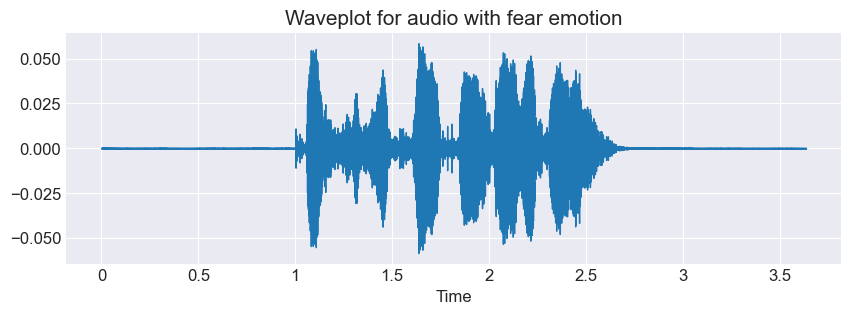

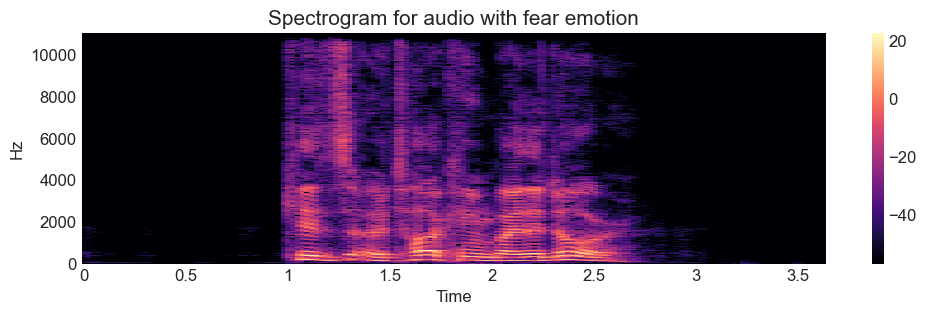

In [41]:
emotion='fear'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

### 4. Data Augmentation :

In [42]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(RAV_df.path)[1]
data, sample_rate = librosa.load(path)

#### 4.1 Simple Audio:

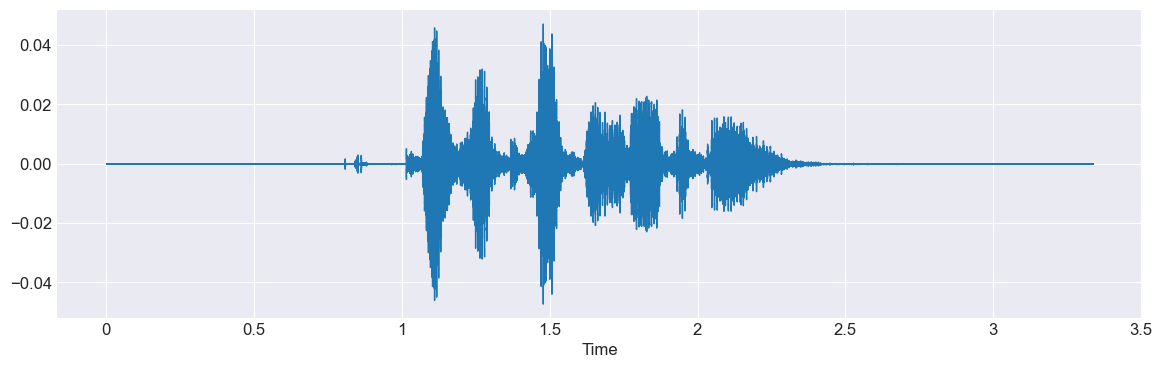

In [43]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
ipd.Audio(path)

#### 4.2 Noise Injection :

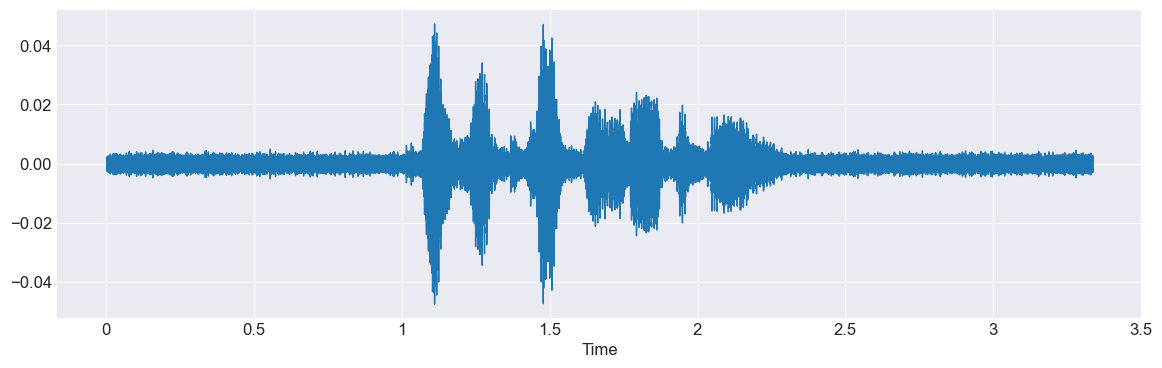

In [44]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

#### 4.3 Stretching :

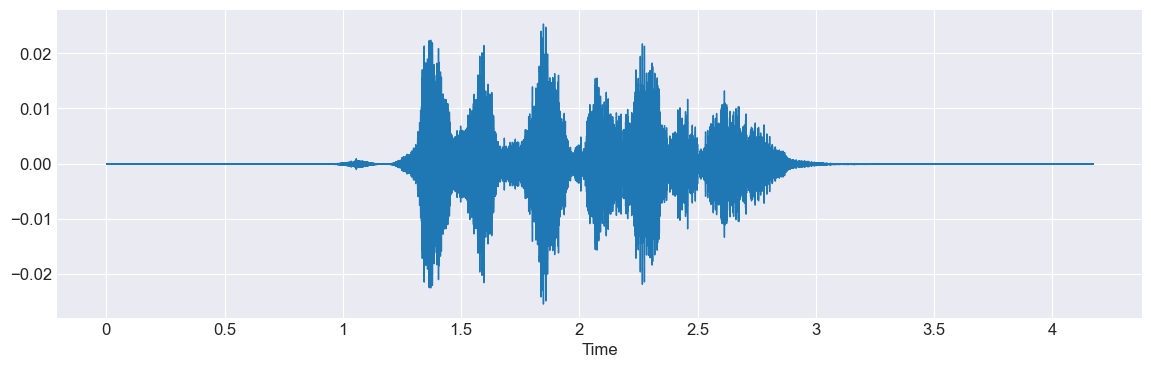

In [45]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

#### 4.4 Shifting :

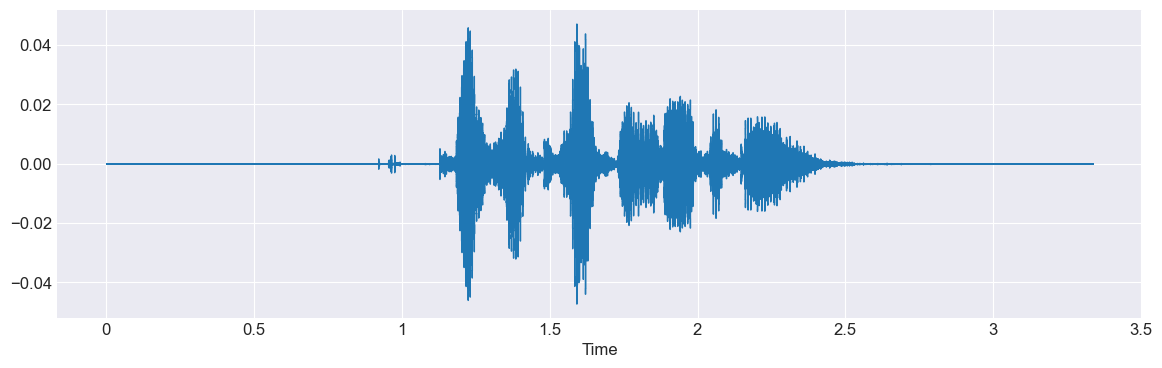

In [46]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

#### 4.5 Pitch :

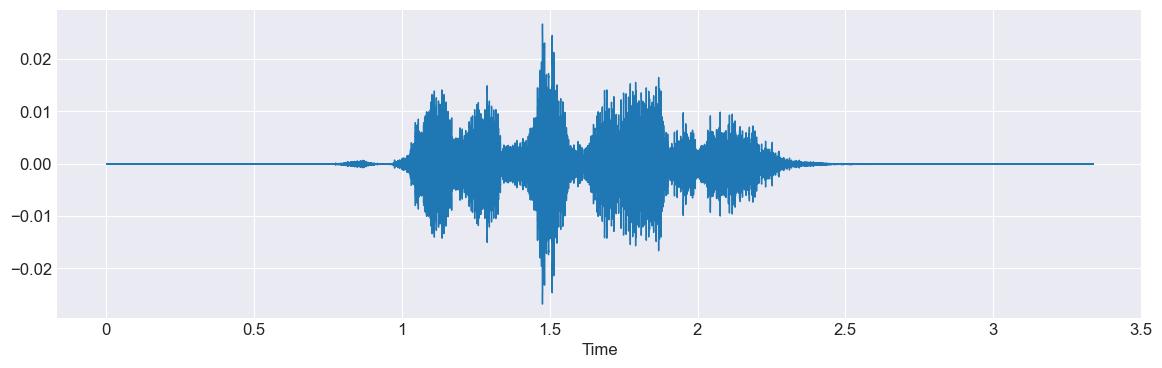

In [47]:
x = pitch(data,sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

### 5 Feature Extraction :

In [48]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

### 6. Data Preperation

In [49]:
X, Y = [], []
for path, emotion in zip(RAV_df.path, RAV_df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [50]:
len(X), len(Y), RAV_df.path.shape

(4320, 4320, (1440,))

In [51]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [52]:
display(Features.head())
display(Features.describe())

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750032,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753971,...,4.310903e-06,3.291511e-06,2.148075e-06,2.279739e-06,5.116493e-06,8.190282e-06,0.000007,0.000005,4.245834e-07,neutral
1,0.328360,0.786114,0.831818,0.824754,0.822580,0.827510,0.730199,0.674337,0.719757,0.757974,...,1.085281e-04,1.054075e-04,1.110288e-04,1.124680e-04,1.056501e-04,1.124262e-04,0.000107,0.000112,1.075812e-04,neutral
2,0.188285,0.622130,0.699225,0.753333,0.721221,0.701736,0.682347,0.662826,0.686491,0.733961,...,8.577343e-07,9.576414e-07,7.733593e-07,5.233101e-07,3.592793e-07,9.261689e-07,0.000002,0.000001,7.753987e-08,neutral
3,0.293566,0.673896,0.722096,0.723508,0.682302,0.680533,0.675352,0.628977,0.679179,0.707283,...,6.984504e-06,7.034949e-06,6.654923e-06,6.979548e-06,1.214236e-05,9.640183e-06,0.000011,0.000006,4.254087e-07,neutral
4,0.336797,0.804047,0.841438,0.819592,0.806313,0.805751,0.705767,0.667845,0.724940,0.748539,...,1.764836e-04,1.754774e-04,1.628115e-04,1.673674e-04,1.834879e-04,1.743377e-04,0.000158,0.000167,1.584563e-04,neutral


,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
count,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,...,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03
mean,0.210618,0.627981,0.631115,0.635794,0.645927,0.634927,0.606348,0.600959,0.620154,0.637522,...,1.831687e-03,1.838478e-03,1.880567e-03,1.924221e-03,1.968318e-03,2.005238e-03,1.999298e-03,1.959400e-03,1.464409e-03,8.336465e-04
std,0.068832,0.088204,0.097780,0.100868,0.102447,0.104824,0.091344,0.078686,0.080757,0.079418,...,6.669284e-03,6.658869e-03,6.758348e-03,7.047500e-03,7.180844e-03,7.232156e-03,7.153253e-03,6.960254e-03,5.919102e-03,4.862948e-03
min,0.060041,0.339261,0.287355,0.274467,0.261137,0.263633,0.269493,0.262952,0.242524,0.269620,...,2.135828e-08,1.693192e-08,2.129202e-08,2.401509e-08,2.901207e-08,2.325075e-08,6.040975e-08,7.742786e-08,3.496108e-08,2.158392e-09
25%,0.154505,0.568822,0.565112,0.565353,0.575898,0.565313,0.549105,0.553448,0.568775,0.586375,...,2.868679e-05,2.938913e-05,3.025780e-05,3.183864e-05,3.462883e-05,3.405298e-05,3.434908e-05,3.345386e-05,2.003578e-05,1.986758e-06
50%,0.201732,0.629991,0.636340,0.640682,0.651869,0.641842,0.614997,0.609319,0.626777,0.643975,...,1.677606e-04,1.674903e-04,1.693320e-04,1.788952e-04,1.842047e-04,1.845986e-04,1.879157e-04,1.844516e-04,1.146434e-04,1.433764e-05
75%,0.265861,0.691434,0.701581,0.710554,0.721445,0.708787,0.669705,0.655263,0.677431,0.693140,...,9.038508e-04,8.942299e-04,9.523729e-04,9.218918e-04,9.434820e-04,9.593599e-04,9.575151e-04,9.611966e-04,6.248094e-04,1.119309e-04
max,0.407457,0.879145,0.871745,0.897299,0.897991,0.908488,0.858973,0.790405,0.833317,0.868183,...,1.266588e-01,1.265192e-01,1.246416e-01,1.197908e-01,1.178683e-01,1.069827e-01,1.268136e-01,1.281950e-01,1.060401e-01,8.412973e-02


In [53]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [54]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [55]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 7), (1080, 162), (1080, 7))

In [56]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 7), (1080, 162), (1080, 7))

In [24]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 7), (1080, 162, 1), (1080, 7))

In [23]:
print("Shapes after split:")
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

Shapes after split:
x_train: (3240, 162) y_train: (3240, 7)
x_test: (1080, 162) y_test: (1080, 7)


### 7. Modelling :

# CNN Architecture 1 :

In [24]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

C:\Users\hp\anaconda4\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)          │      1,536 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 128)           │    163,968 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 128)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 64)            │     41,024 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 64)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 21, 64)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 32)            │     10,272 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 32)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 352)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 16)                │      5,648 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 16)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 7)                 │        119 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 222,567 (869.40 KB)

 Trainable params: 222,567 (869.40 KB)

 Non-trainable params: 0 (0.00 B)

### 8. Training :

In [27]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.1948 - loss: 1.8946 - val_accuracy: 0.3231 - val_loss: 1.7346 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.2706 - loss: 1.8056 - val_accuracy: 0.3491 - val_loss: 1.6574 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.2681 - loss: 1.7602 - val_accuracy: 0.3833 - val_loss: 1.6780 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.2859 - loss: 1.7265 - val_accuracy: 0.3769 - val_loss: 1.6017 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3069 - loss: 1.7095 - val_accuracy: 0.4231 - val_loss: 1.5548 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.3492 - loss: 1.6482 - val_accuracy: 0.4185 - val_loss: 1.5227 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.3421 - loss: 1.6449 - val_ac

###  Evaluation of the first model

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6126 - loss: 1.2655
Accuracy of our model on test data :  61.38888597488403 %


C:\Users\hp\AppData\Local\Temp\ipykernel_17812\1215274044.py:3: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



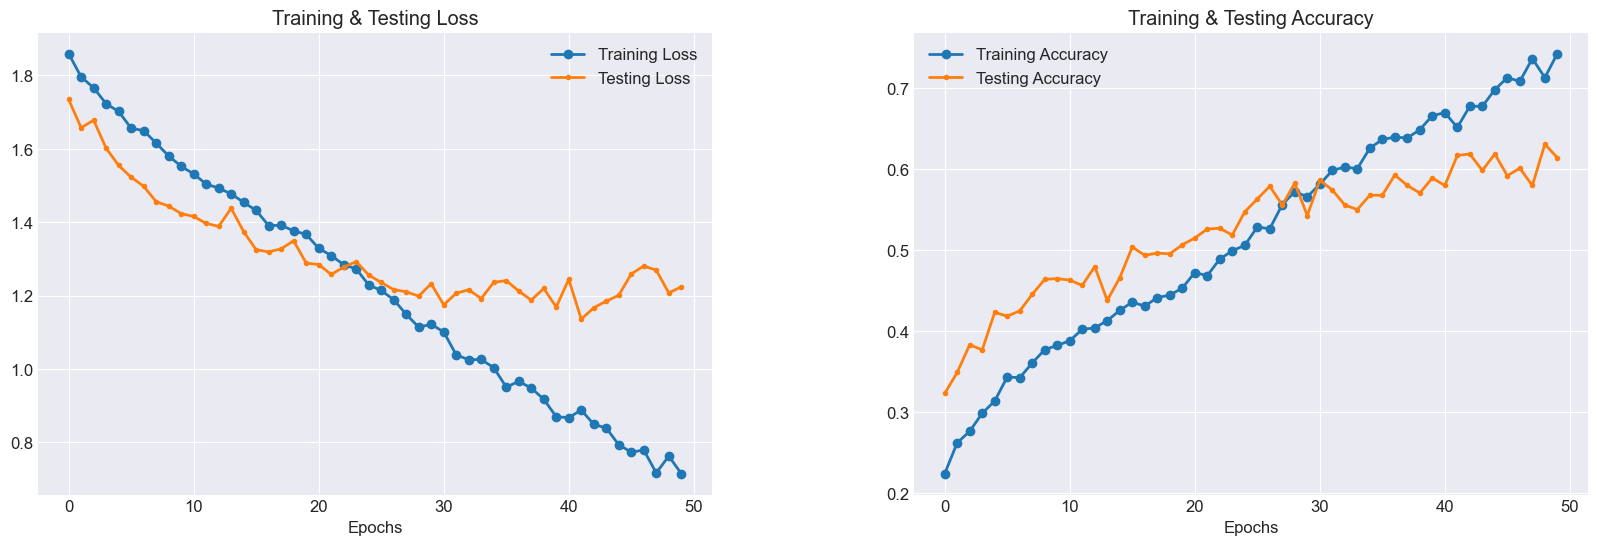

In [28]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 12})
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss',marker='o', linewidth=2)
ax[0].plot(epochs , test_loss , label = 'Testing Loss',marker='.', linewidth=2)
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy',marker='o', linewidth=2)
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy',marker='.', linewidth=2)
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.subplots_adjust(wspace=0.3)
plt.show()

In [29]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [30]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

display(df.head())

,Predicted Labels,Actual Labels
0,fear,fear
1,angry,angry
2,fear,fear
3,neutral,neutral
4,happy,angry


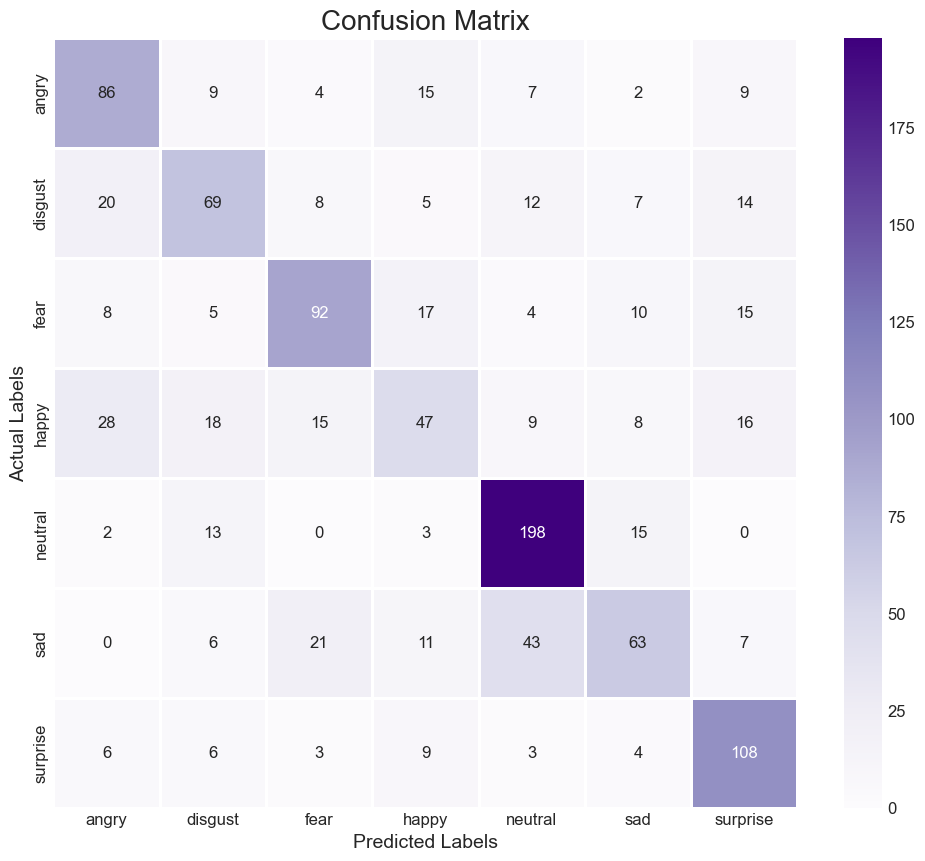

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.57      0.65      0.61       132
     disgust       0.55      0.51      0.53       135
        fear       0.64      0.61      0.63       151
       happy       0.44      0.33      0.38       141
     neutral       0.72      0.86      0.78       231
         sad       0.58      0.42      0.48       151
    surprise       0.64      0.78      0.70       139

    accuracy                           0.61      1080
   macro avg       0.59      0.59      0.59      1080
weighted avg       0.60      0.61      0.60      1080



# CNN Architecture 2 :

In [117]:
model = Sequential()
model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(0.25))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(0.25))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 32
epochs = 50

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/50
102/102 [==============================] - 8s 55ms/step - loss: 1.7800 - accuracy: 0.2873 - val_loss: 1.5969 - val_accuracy: 0.3861 - lr: 0.0010
Epoch 2/50
102/102 [==============================] - 5s 54ms/step - loss: 1.6164 - accuracy: 0.3728 - val_loss: 1.4730 - val_accuracy: 0.4463 - lr: 0.0010
Epoch 3/50
102/102 [==============================] - 6s 54ms/step - loss: 1.5150 - accuracy: 0.4188 - val_loss: 1.3479 - val_accuracy: 0.4741 - lr: 0.0010
Epoch 4/50
102/102 [==============================] - 6s 57ms/step - loss: 1.4564 - accuracy: 0.4457 - val_loss: 1.3217 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 5/50
102/102 [==============================] - 6s 55ms/step - loss: 1.3934 - accuracy: 0.4710 - val_loss: 1.2481 - val_accuracy: 0.5231 - lr: 0.0010
Epoch 6/50
102/102 [==============================] - 6s 56ms/step - loss: 1.3368 - accuracy: 0.5052 - val_loss: 1.2045 - val_accuracy: 0.5565 - lr: 0.0010
Epoch 7/50
102/102 [==============================] - 6s 60ms/st

# Evaluation of the second model

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7499 - loss: 0.7842
Accuracy of our model on test data :  75.46296119689941 %


C:\Users\hp\AppData\Local\Temp\ipykernel_17812\1215274044.py:3: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



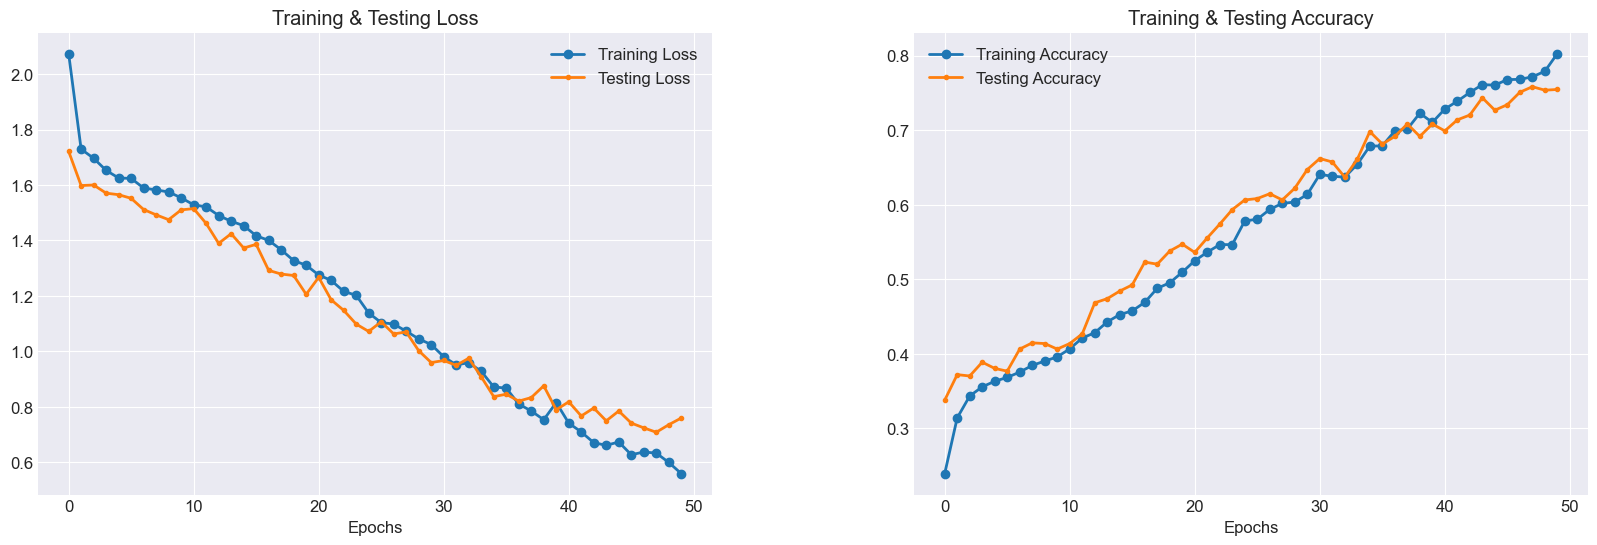

In [90]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 12})
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss',marker='o', linewidth=2)
ax[0].plot(epochs , test_loss , label = 'Testing Loss',marker='.', linewidth=2)
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy',marker='o', linewidth=2)
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy',marker='.', linewidth=2)
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.subplots_adjust(wspace=0.3)
plt.show()

In [118]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 1s 11ms/step


In [119]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

display(df.head())

,Predicted Labels,Actual Labels
0,fear,fear
1,disgust,angry
2,fear,fear
3,neutral,neutral
4,angry,angry


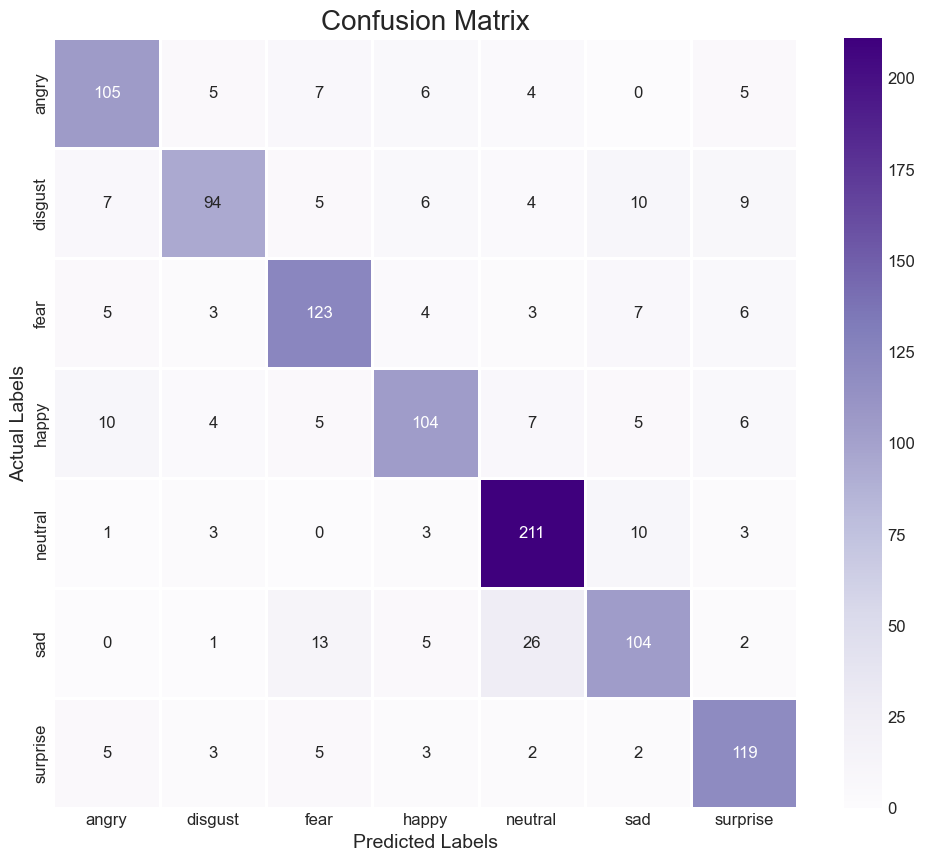

In [120]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.79      0.80      0.79       132
     disgust       0.83      0.70      0.76       135
        fear       0.78      0.81      0.80       151
       happy       0.79      0.74      0.76       141
     neutral       0.82      0.91      0.86       231
         sad       0.75      0.69      0.72       151
    surprise       0.79      0.86      0.82       139

    accuracy                           0.80      1080
   macro avg       0.79      0.79      0.79      1080
weighted avg       0.80      0.80      0.79      1080



# Visualization of Training Data Over Time

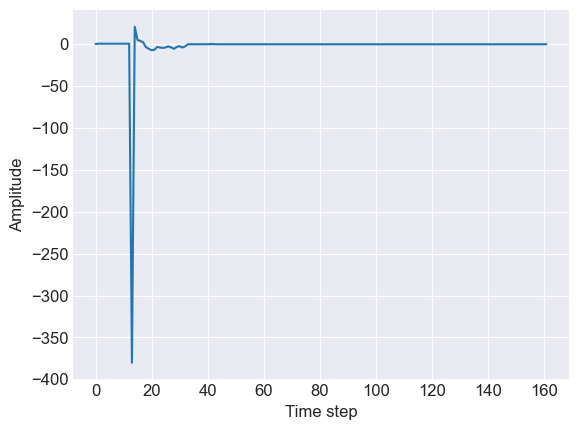

In [99]:
import matplotlib.pyplot as plt

plt.plot(x_train[0])
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.show()

# Evaluating Real Voice Recordings

In [58]:
!pip install sounddevice wavio


  Obtaining dependency information for sounddevice from https://files.pythonhosted.org/packages/39/ae/5e84220bfca4256e4ca2a62a174636089ab6ff671b5f9ddd7e8238587acd/sounddevice-0.4.6-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for wavio from https://files.pythonhosted.org/packages/bf/02/40d03e99a3d2d8d1e9392f44376f470120427ffb12483579dc7e0365f712/wavio-0.0.8-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/199.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/199.7 kB ? eta -:--:--
   -- ------------------------------------- 10.2/199.7 kB ? eta -:--:--
   ----- --------------------------------- 30.7/199.7 kB 325.1 kB/s eta 0:00:01
   ----------------- --------------------- 92.2/199.7 kB 751.6 kB/s eta 0:00:01
   -------------------------------------- - 194.6/199.7 kB 1.2 MB/s eta 0:00:01
   -------------------------------------- - 194.6/199.7 kB 1.2 MB/s eta 0:00:01
   -------------------------------------- - 194.6/199.7 kB

# Record your voice :

In [113]:
import sounddevice as sd
import wavio

def record_audio(filename, duration=5, fs=44100):
    print("Recording...")
    myrecording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='int16')
    sd.wait()  
    print("Recording finished")
    wavio.write(filename, myrecording, fs, sampwidth=2)
    return filename

# Record your voice and save it to a file
audio_file = "my_voice.wav"
record_audio(audio_file)


Recording...
Recording finished


'my_voice.wav'

In [114]:
from IPython.display import Audio
Audio(audio_file)


In [115]:
def get_features_from_audio_file(audio_file):
    return get_features(audio_file)

features = get_features_from_audio_file(audio_file)


In [108]:
features

array([[ 3.41344763e-02,  6.13969862e-01,  5.55919707e-01,
         4.79888082e-01,  4.76462185e-01,  4.71108764e-01,
         4.50636446e-01,  5.19795835e-01,  5.09275675e-01,
         3.64634961e-01,  3.43720406e-01,  4.15923715e-01,
         5.62719285e-01, -3.57673767e+02,  1.14529137e+02,
        -2.24162941e+01,  9.02452850e+00,  2.15991592e+01,
         8.47670269e+00,  2.57592564e+01,  1.75798359e+01,
         4.55060768e+00, -7.16996384e+00,  2.98597741e+00,
         9.77944851e+00, -3.93591762e+00,  8.18707657e+00,
        -5.59054756e+00, -5.20563984e+00,  3.50110793e+00,
        -7.51637220e-01,  2.71655321e+00,  2.99010515e-01,
         7.54140764e-02,  1.77914016e-02,  7.16544688e-02,
         4.82291508e+00,  4.68239641e+00,  6.72783405e-02,
         3.26623172e-02,  2.50497982e-02,  1.30477428e+00,
         3.69590988e+01,  1.23580032e+02,  3.70725021e+01,
         3.25063020e-01,  2.76917461e-02,  1.05034700e-02,
         6.88690646e-03,  5.01602236e-03,  9.38674901e-0

In [116]:
from tensorflow.keras.models import load_model

emotion_mapping = {1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}

# Predict emotion
predictions = model.predict(features)
predicted_emotion = np.argmax(predictions, axis=1)

# Debug: Print raw predictions and the predicted emotion index
print("Raw Predictions:", predictions)
print("Predicted Emotion Index:", predicted_emotion[0])

# Map the predicted emotion index to its label
predicted_label = emotion_mapping.get(predicted_emotion[0], "Unknown")
print(f"Predicted Emotion: {predicted_label}")

1/1 [==============================] - 0s 29ms/step
Raw Predictions: [[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]
Predicted Emotion Index: 4
Predicted Emotion: sad
